In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in onboard data and pivot it in preparation for merging with J1939 worksheet
onboard = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv')
ob_data = onboard.pivot(index='FaultId', columns='Name',values = 'Value').rename_axis(None)
pd.set_option('display.max_columns', None)
ob_data.reset_index(inplace=True)
ob_data = ob_data.rename(columns = {'index':'RecordID'})

In [3]:
# Read in J1939 worksheet and pivot it in preparation for merging with onboard data
derates = pd.read_csv('../data/J1939Faults.csv')
derates = derates.drop(columns=['actionDescription', 'faultValue'])
derates = derates[~((derates['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (derates['Latitude'].astype('str').str.contains(r'35.58\d+')))]
derates = derates[~((derates['Longitude'].astype('str').str.contains(r'-86.43\d+')) & (derates['Latitude'].astype('str').str.contains(r'36.07\d+')))]
derates = derates[~((derates['Longitude'].astype('str').str.contains(r'-83.17\d+')) & (derates['Latitude'].astype('str').str.contains(r'36.20\d+')))]
derates['EquipmentID'] = derates['EquipmentID'].astype(str)
derates = derates[derates['EquipmentID'].str.len() < 6]

C:\Users\hjrko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Merge J1939 and onboard dataframes
derates_onboard_merged = derates.merge(ob_data, on='RecordID')
derates_onboard_merged['EventTimeStamp'] = pd.to_datetime(derates_onboard_merged['EventTimeStamp'])
derates_onboard_merged['LocationTimeStamp'] = pd.to_datetime(derates_onboard_merged['LocationTimeStamp'])

In [5]:
derates_onboard_merged[derates_onboard_merged['EquipmentID'] == '305']

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
48,53,991047,2015-02-21 12:18:36,Special Instructions System Diagnostic Code #1,unknown,unknown,unknown,unknown,11,611,14,False,127,305,105362919,33.673379,-84.340185,2015-02-21 12:18:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
49,54,991048,2015-02-21 12:18:36,Special Instructions Wheel Sensor ABS Axle 2 Left,unknown,unknown,unknown,unknown,11,791,14,False,127,305,105362919,33.673379,-84.340185,2015-02-21 12:18:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
50,55,991056,2015-02-21 12:19:17,Data May Be Invalid Relative Speed; Rear Axle ...,unknown,unknown,unknown,unknown,0,907,19,False,2,305,105362919,33.673750,-84.340324,2015-02-21 12:19:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
51,56,991057,2015-02-21 12:18:38,Special Instructions System Diagnostic Code #1,unknown,unknown,unknown,unknown,11,611,14,True,127,305,105362919,33.673750,-84.340324,2015-02-21 12:19:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
52,57,991058,2015-02-21 12:18:38,Special Instructions Wheel Sensor ABS Axle 2 Left,unknown,unknown,unknown,unknown,11,791,14,True,127,305,105362919,33.673750,-84.340324,2015-02-21 12:19:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150234,1236374,118262826,2020-01-24 08:17:55,Error in System Engine Exhaust Gas Recirculati...,PC4_C1408P151H*,Y048665,MX16U15D13,PCAR,0,2791,11,False,1,305,105356102,35.485231,-86.076759,2020-01-24 08:17:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1158944,1246390,122739689,2020-02-27 12:03:29,High Voltage (Left Fuel Level Sensor),unknown,unknown,unknown,unknown,49,829,3,True,126,305,105356102,35.490185,-86.410324,2020-02-27 12:04:06,0,14.4275,False,0,337164.3,174.2,7,31.9,190.0063,648.75,13754.2,66,54429.613336002,0.3962593,86,True,118.4,1279,False,NaN,0,NaN,0,0.29
1158945,1246391,122739690,2020-02-27 12:03:29,High Voltage (Fuel Level),unknown,unknown,unknown,unknown,49,96,3,True,126,305,105356102,35.490185,-86.410324,2020-02-27 12:04:06,0,14.4275,False,0,337164.3,174.2,7,31.9,190.0063,648.75,13754.2,66,54429.613336002,0.3962593,86,True,118.4,1279,False,NaN,0,NaN,0,0.29
1158949,1246395,122740255,2020-02-27 12:08:48,High Voltage (Fuel Level),unknown,unknown,unknown,unknown,49,96,3,False,126,305,105356102,35.491018,-86.409583,2020-02-27 12:08:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
condensed_df = derates_onboard_merged.sort_values(['EquipmentID', 'EventTimeStamp', 'spn', 'fmi'])[['EquipmentID', 'EventTimeStamp', 'eventDescription', 'spn', 'fmi', 'active', 'activeTransitionCount']]

mask = ((test2['spn'] == 5246) |
        (test2['spn'].shift(-1) == 5246))

spn_prior_to_derate = condensed_df[mask]

spn_count = spn_prior_to_derate.groupby('spn').count().reset_index()
spn_count = spn_count[~(spn_count['spn'] == 5246)].sort_values('EquipmentID', ascending=False).head(20)

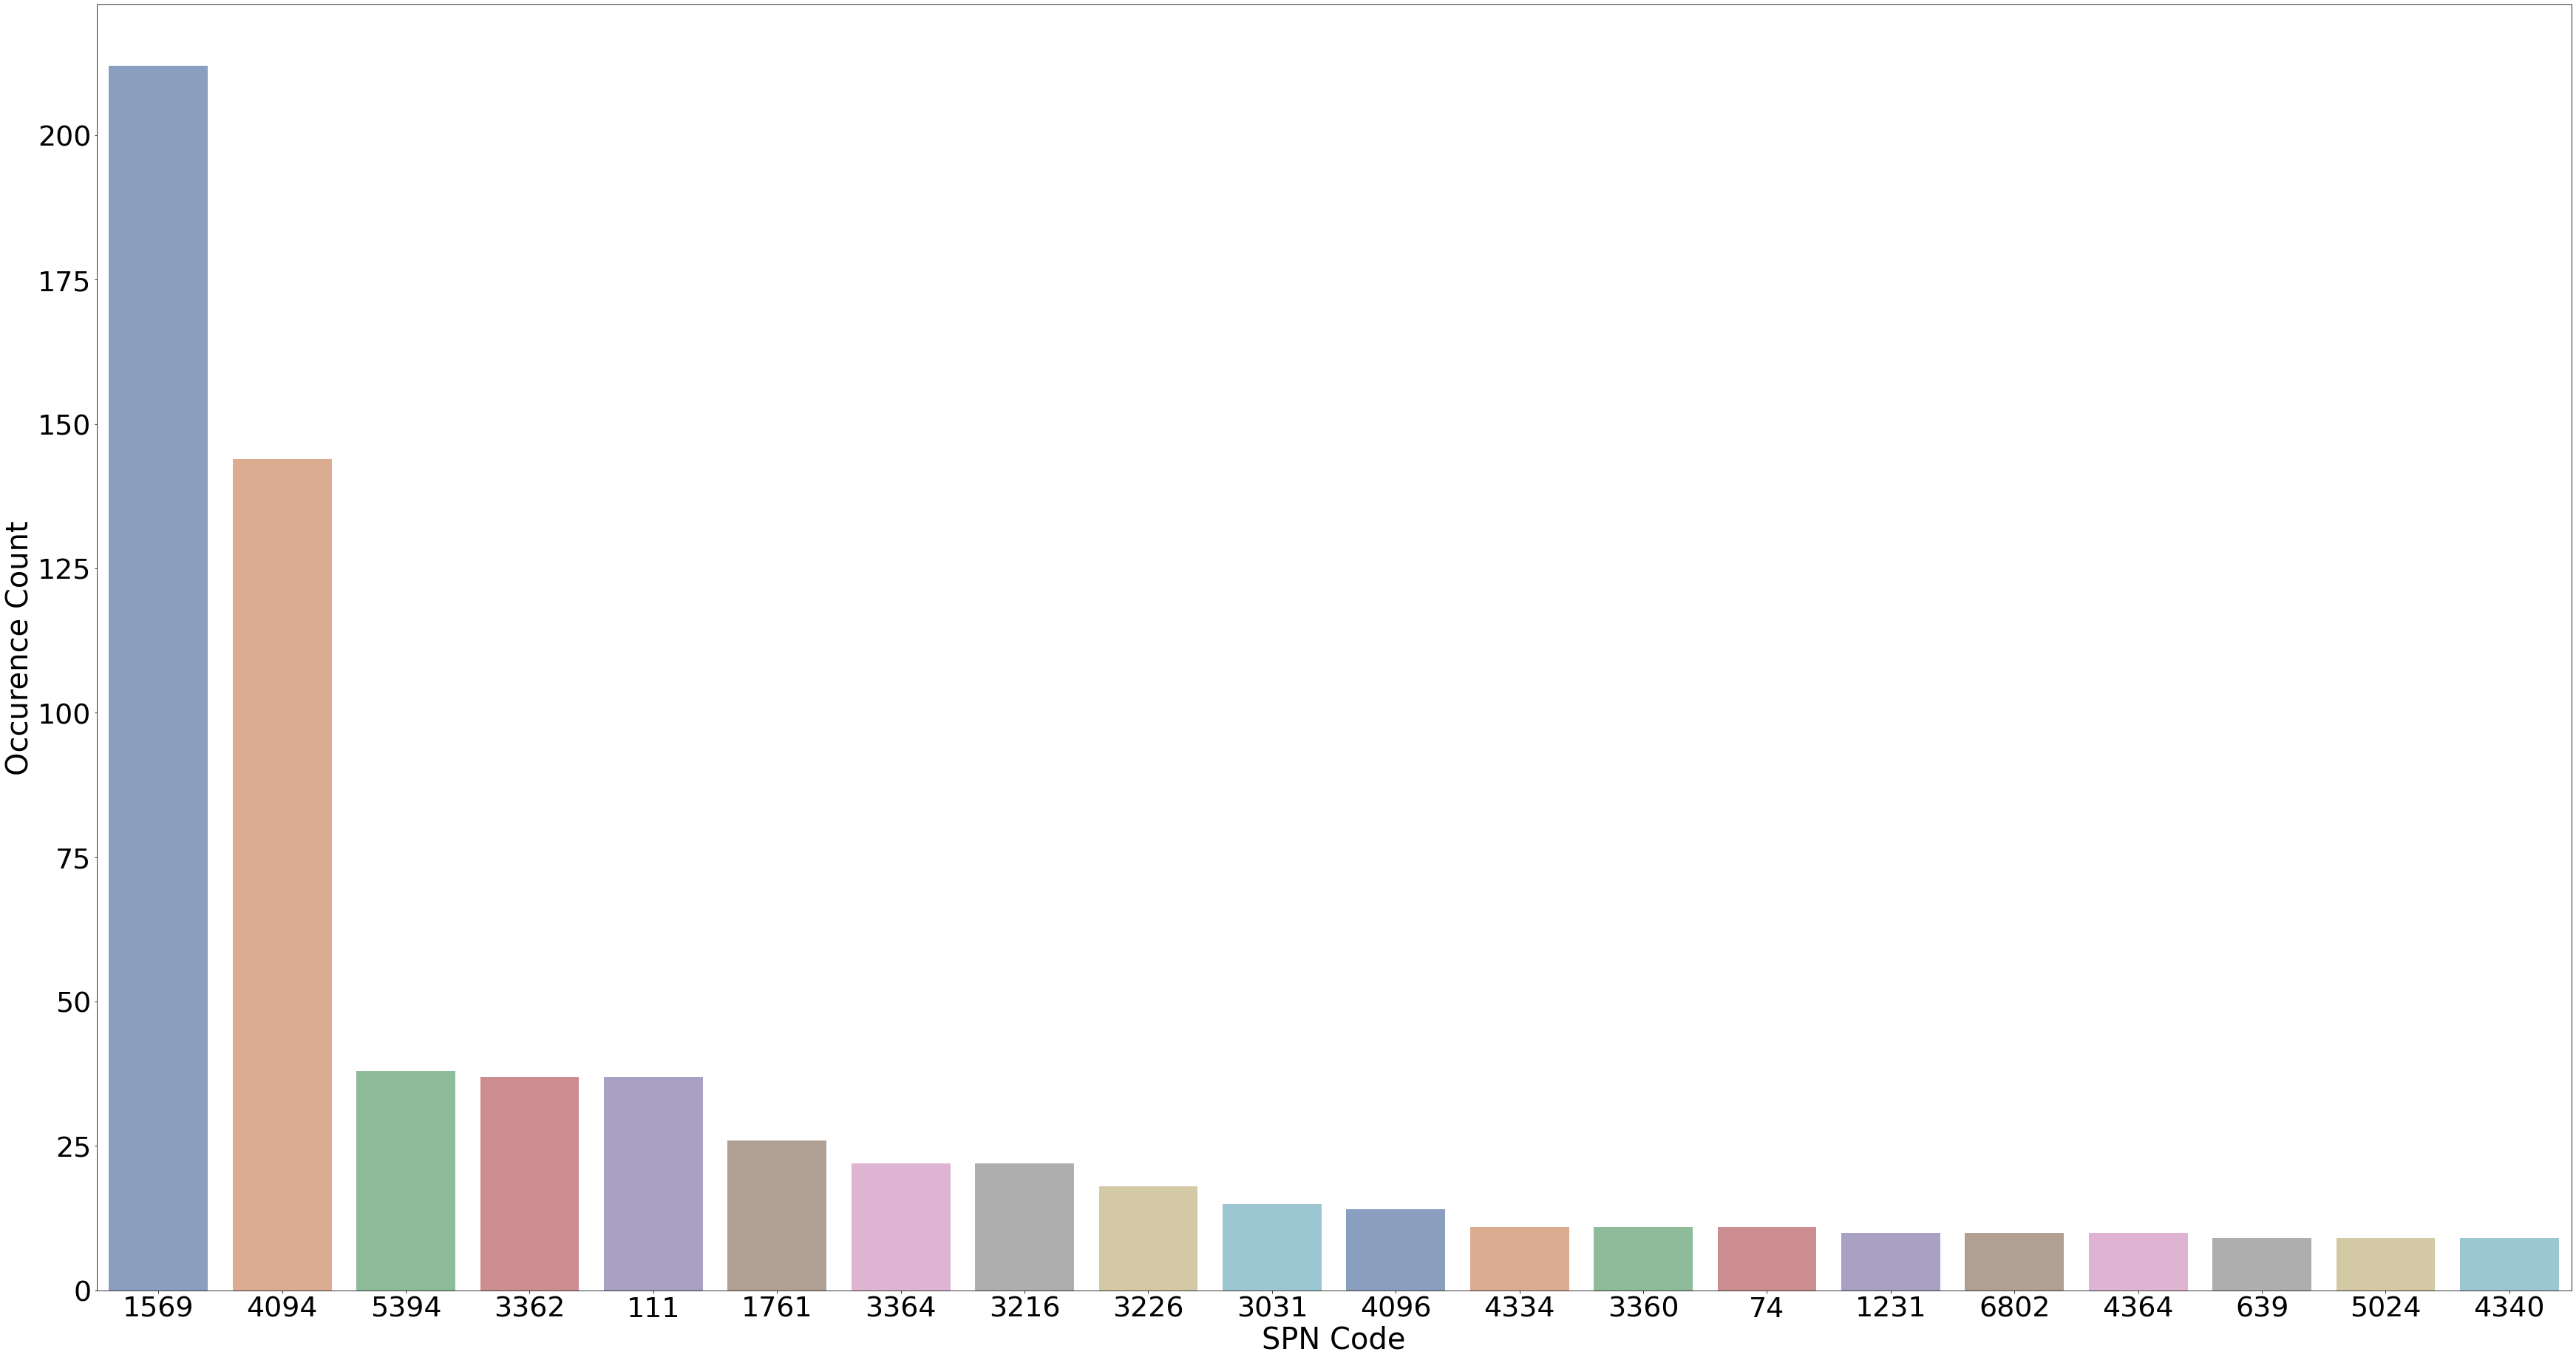

In [89]:
fontsize = 40

fig, ax = plt.subplots(figsize=(60, 32))
sns.barplot(x = 'spn', 
            y = 'EquipmentID', 
            data = spn_count, 
            dodge = False, 
            palette = "deep",
            ax = ax,
            alpha = 0.7,
            order = spn_count.sort_values('EquipmentID', ascending=False).spn)

plt.xlabel('SPN Code', fontsize = fontsize)
plt.xticks(fontsize = fontsize - 2)

plt.ylabel('Occurence Count', fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)

plt.title('');

In [62]:
pd.set_option('display.max_rows', 10)
spn_count

,spn,EquipmentID,EventTimeStamp,eventDescription,fmi,active,activeTransitionCount
54,4363,1,1,0,1,1,1
55,4364,10,10,0,10,10,10
56,4375,4,4,0,4,4,4
57,4376,5,5,0,5,5,5
58,4765,2,2,0,2,2,2
...,...,...,...,...,...,...,...
70,5848,8,8,0,8,8,8
71,6802,10,10,0,10,10,10
72,51923,1,1,0,1,1,1
73,520953,1,1,0,1,1,1


In [57]:
service_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
0,Y,111,167,Not Mapped,254,0,12,629,12,P0606,Red,Stop / Shutdown,Engine Control Module Critical Internal Failur...,Error internal to the ECM related to memory ha...
1,Y,112,167,Not Mapped,20,128,7,635,7,Not Mapped,Red,Stop / Shutdown,Engine Timing Actuator Driver Circuit - Mechan...,Mechanical failure in the engine timing actuat...
2,Y,113,167,Not Mapped,20,128,3,635,3,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,High signal voltage detected at the engine tim...
3,Y,114,167,Not Mapped,20,128,4,635,4,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,Low voltage detected at the engine timing actu...
4,Y,115,167,190,Not Mapped,Not Mapped,2,612,2,P0008,Red,Stop / Shutdown,Engine Magnetic Speed/Position Lost Both of Tw...,The ECM has detected that the primary and back...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7119,Y,9996,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7120,Y,9997,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7121,Y,9998,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7122,Y,9999,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN


In [59]:
service_codes[service_codes['SPN'] == 5394]

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
2404,Y,3565,167,Not Mapped,Not Mapped,Not Mapped,3,5394,3,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
2405,Y,3566,167,Not Mapped,Not Mapped,Not Mapped,4,5394,4,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
2406,Y,3567,167,Not Mapped,Not Mapped,Not Mapped,5,5394,5,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
2407,Y,3568,167,Not Mapped,Not Mapped,Not Mapped,7,5394,7,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
2557,Y,3755,167,Not Mapped,Not Mapped,Not Mapped,2,5394,2,P204F,None,None,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
3106,Y,4535,167,Not Mapped,Not Mapped,Not Mapped,2,5394,2,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,NaN
3976,Y,5712,167,Not Mapped,Not Mapped,Not Mapped,11,5394,11,Not Mapped,Amber,Warning,Aftertreatment 1 Diesel Exhaust Fluid Dosing V...,Stuck open diagnostic
